In [1]:
cd ..

C:\Users\giaco\sbp-abm\municipalities_abm


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import csv

from municipalities_abm.model import SBPAdoption

from municipalities_abm.custom_transformers import (
    TransformCensusFeaturesClsf,
    TransformCensusFeaturesRegr,
    TransformClimateFeatures,
    TransformSoilFeatures,
    )

%matplotlib inline

In [3]:
# Line necessary to import agents in model, since the cwd of the notebook server is always the base path where you started the 
# server 
import sys
sys.path.append(".\municipalities_abm")

In [4]:
# How to display floats
pd.options.display.float_format = '{:.6f}'.format
#np.set_printoptions(precision=6)
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})

In [5]:
# Where to save the figures
PROJECT_ROOT_DIR = "model_validation"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=False, fig_extension="jpeg", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Real data loading

In [6]:
path_to_adoption_port_real = "./model_validation/data/SBP yearly adoption - Portugal.csv"
yearly_adoption_portugal_real = pd.read_csv(path_to_adoption_port_real, index_col=0)
yearly_adoption_portugal_real.drop(1995, inplace=True)

In [7]:
path_to_adoption_munic_real = "./model_validation/data/SBP yearly adoption - Municipalities.csv"
munic_yearly_adoption_real = pd.read_csv(path_to_adoption_munic_real, index_col=['Municipality', 'Year'])

# Model runs and data collection

In [8]:
n_runs = 1

In [9]:
start_year = 1996
stop_year = 2025

### Set dataframe and function to collect municipalities yearly adoption

In [10]:
# Set dataframe to collect municipalities yearly adoption
municipalities_data = gpd.read_file("./data/municipalities_shp/shapefile_for_munic_abm.shp")
municipalities_data.rename(columns={'Municipali': 'Municipality'},
                           inplace=True)
municipalities = municipalities_data['Municipality'].values.tolist()

years = np.arange(start_year, stop_year)
munic_yearly_adoption = pd.MultiIndex.from_product([municipalities, years])
munic_yearly_adoption = munic_yearly_adoption.to_frame()
munic_yearly_adoption.drop(munic_yearly_adoption.columns, axis=1, inplace=True)
munic_yearly_adoption.index.rename(['Municipality', 'Year'], inplace=True)

In [11]:
def collect_agent_level_yearly_adoption(abm_model, n_run, df_adoption):
    """
    Function to collect data at the individual agent level
    
    Returns
    -------
    municipalities_adoption : pd DataFrame
        Multiindex DataFrame reporting for each muninicipality and for each year the ratio of SBP adopted
    """
    municipality_agents = abm_model.schedule.agents
    col_name = 'Run ' + str(n_run+1)
    df_adoption.loc[:, col_name] = None
    
    # Create a dictionary mapping to each municipality name the Series of its adoption in each year
    yearly_adoptions = [munic.yearly_adoption for munic in municipality_agents]
    map_dict = dict(zip(municipalities, yearly_adoptions))
    for k, v in map_dict.items():
        map_dict[k] = pd.Series(v)
        map_dict[k].name = col_name # Necessary to use .udpdate() method

    # For each municipality, updates the values of adoption    
    for munic in municipalities:
        df = df_adoption.loc[munic]
        df.update(map_dict[munic])
        df_adoption.loc[munic] = df.values

### Set dataframes to collect yearly adoption and cumulative yearly adoption in Portugal

In [12]:
# Set dataframes to collect yearly adoption and cumulative yearly adoption in Portugal
yearly_adoption_portugal_pred = pd.DataFrame(index=years)
yearly_adoption_portugal_pred.index.rename('Year', inplace=True)

cumulative_adoption_portugal_pred = pd.DataFrame(index=years)
cumulative_adoption_portugal_pred.index.rename('Year', inplace=True)

In [13]:
def collect_data_run(model, n_run):
    # Individual adoption
    collect_agent_level_yearly_adoption(model, n_run, munic_yearly_adoption)
    
    # Aggregate adoption
    aggr_adoption_out = model.datacollector.get_model_vars_dataframe()
    aggr_adoption_out.set_index('Year', inplace=True)
    col_name = 'Run ' + str(n_run+1)
    yearly_adoption_portugal_pred[col_name] = aggr_adoption_out['Area sown in the last year [ha/y]']
    cumulative_adoption_portugal_pred[col_name] = aggr_adoption_out['Total area of SBP sown [ha]']

In [14]:
%%time
for i in range(n_runs):
    #model = SBPAdoption(initial_year=start_year, seed=i, sbp_payments_path=sbp_payments_path)
    model = SBPAdoption(initial_year=start_year, seed=i)
    for y in range(start_year, stop_year):
        model.step()
        print("Run n° " + str(i+1) + ": year " + str(y) + " step completed.")
    collect_data_run(model, i)

Negative adoption predicted of: [-0.000099]
Run n° 1: year 1996 step completed.
Negative adoption predicted of: [-0.000099]
Run n° 1: year 1997 step completed.
Negative adoption predicted of: [-0.000099]
Run n° 1: year 1998 step completed.
Negative adoption predicted of: [-0.000099]
Run n° 1: year 1999 step completed.
Negative adoption predicted of: [-0.000099]
Run n° 1: year 2000 step completed.
Negative adoption predicted of: [-0.000099]
Run n° 1: year 2001 step completed.
Negative adoption predicted of: [-0.000099]
Run n° 1: year 2002 step completed.
Negative adoption predicted of: [-0.000099]
Run n° 1: year 2003 step completed.
Negative adoption predicted of: [-0.000099]
Run n° 1: year 2004 step completed.
Negative adoption predicted of: [-0.000099]
Run n° 1: year 2005 step completed.
Negative adoption predicted of: [-0.000099]
Run n° 1: year 2006 step completed.
Run n° 1: year 2007 step completed.
Negative adoption predicted of: [-0.000099]
Run n° 1: year 2008 step completed.
Nega

In [15]:
munic_yearly_adoption.head(10)

Run 1
Municipality Year         
Évora        1996 0.000000
             1997 0.002298
             1998 0.003336
             1999 0.004073
             2000 0.004791
             2001 0.005578
             2002 0.006467
             2003 0.007477
             2004 0.008618
             2005 0.009901

# Plot of runs and average value over real adoption

In [16]:
if stop_year < 2012:
    yearly_adoption_portugal_real = yearly_adoption_portugal_real.loc[yearly_adoption_portugal_real.index < stop_year]

In [17]:
def plot_adoption_trend_multiple_runs(predicted_adoption, real_adoption, max_y, fig_title):
    """
    Function to plot all the predicted adoptions, the average predicted and the real, in the same graph and save the figure.
    The predicted adoption and real adoption must be pandas Series or DataFrame with as index the years.
    """
    # Base figure
    fig_pr, ax_pr = plt.subplots()
    fig_pr.set_size_inches(10, 5)
    ax_pr.set_xlabel("Years", fontsize=16)
    ax_pr.set_ylabel("Hectares", fontsize=16)
    ax_pr.set_title(fig_title, fontsize=18)
    ax_pr.set_xlim(predicted_adoption.index[0], predicted_adoption.index[-1])
    xticks = [year for year in predicted_adoption.index if year%2 == 0]
    ax_pr.set_xticks(xticks)
    ax_pr.set_ylim(0, max_y)
    ax_pr.grid(True)

    # Plot adoptions
    for col in predicted_adoption.columns:
        ax_pr.plot(predicted_adoption.index, predicted_adoption[col].values, 'b:', linewidth=1, alpha=0.3)
    pred_adoption_av = predicted_adoption.mean(axis=1)
    ax_pr.plot(pred_adoption_av.index, pred_adoption_av.values, 'b--', linewidth=2, marker='.', markersize=9,
               label='Average predicted adoption')    
    ax_pr.plot(real_adoption.index, real_adoption.values, 'r--', linewidth=2, marker='.', markersize=9,
               label='Observed adoption')
    ax_pr.legend(loc='best')

    save_fig((fig_title))  

#### Plot predicted vs real adoption in Portugal

Saving figure Yearly SBP adoption in Portugal


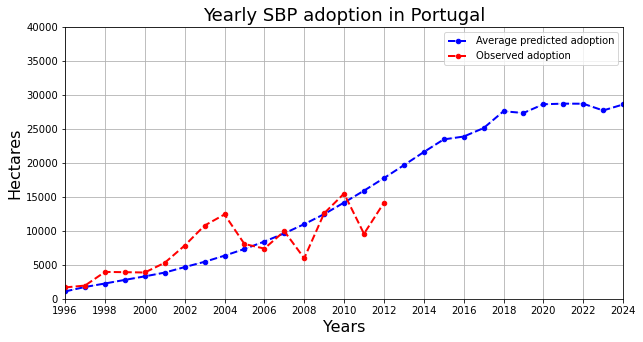

In [49]:
title = "Yearly SBP adoption in Portugal"
plot_adoption_trend_multiple_runs(yearly_adoption_portugal_pred, yearly_adoption_portugal_real, 20000, title)

#### Plot predicted vs real cumulative adoption in Portugal

In [19]:
cumulative_adoption_portugal_real = yearly_adoption_portugal_real.cumsum()

Saving figure Cumulative SBP adoption in Portugal


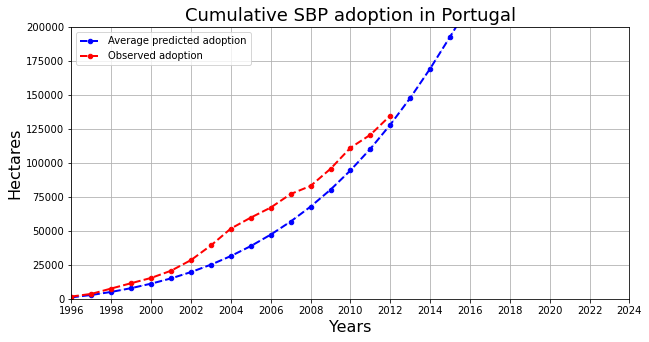

In [20]:
title = "Cumulative SBP adoption in Portugal"
plot_adoption_trend_multiple_runs(cumulative_adoption_portugal_pred, cumulative_adoption_portugal_real, 200000, title)

# Model validation based on average values

In [21]:
munic_yearly_adoption_av = munic_yearly_adoption.mean(axis=1)
munic_yearly_adoption_av.name = "predicted_adoption"

In [22]:
yearly_adoption_portugal_pred_av = yearly_adoption_portugal_pred.mean(axis=1)

In [23]:
cumulative_adoption_portugal_pred_av = cumulative_adoption_portugal_pred.mean(axis=1)

## Macro-validation

### Quantitative

Saving figure Yearly predicted vs. observed adoption


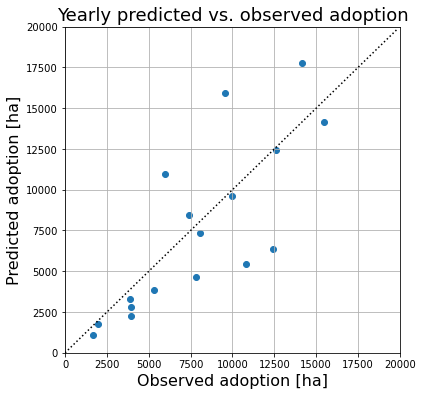

In [24]:
fig_title = "Yearly predicted vs. observed adoption"
fig_pr, ax_pr = plt.subplots()
fig_pr.set_size_inches(6, 6)
ax_pr.set_xlabel("Observed adoption [ha]", fontsize=16)
ax_pr.set_ylabel("Predicted adoption [ha]", fontsize=16)
ax_pr.set_title(fig_title, fontsize=18)
lim = 20000
ax_pr.set_xlim(0, lim)
ax_pr.set_ylim(0, lim)
ax_pr.grid(True)
# Add diagonal
p = np.arange(0, lim, 100)
ax_pr.plot(p, p, 'k:')

yearly_adoption_portugal_pred_av_untill_2012 = yearly_adoption_portugal_pred_av.loc[
    yearly_adoption_portugal_pred_av.index <= 2012
]
ax_pr.scatter(yearly_adoption_portugal_real.values, yearly_adoption_portugal_pred_av_untill_2012.values)
save_fig((fig_title))  

In [25]:
def adjusted_r2(r2, n, p):
    return 1-(1-r2)*(n-1)/(n-p-1)

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(yearly_adoption_portugal_real.values, yearly_adoption_portugal_pred_av_untill_2012))
rrmse = rmse / yearly_adoption_portugal_real.values.std()
mae = mean_absolute_error(yearly_adoption_portugal_real.values, yearly_adoption_portugal_pred_av_untill_2012)
r2 = r2_score(yearly_adoption_portugal_real.values, yearly_adoption_portugal_pred_av_untill_2012)
adj_r2 = adjusted_r2(r2, len(munic_yearly_adoption_av), 21)
print("Cumulative adoption score:")
rmse_str = "RMSE: " + str(rmse)
print(rmse_str)
rrmse_str = "Relative RMSE: " + str(rrmse)
print(rrmse_str)
mae_str = "MAE: " + str(mae)
print(mae_str)
adj_r2_str = "Adjusted R2: " + str(adj_r2)
print(adj_r2_str)

with open("model_validation/images/Macro-validation metrics.csv", "w+", newline ='') as file:
    to_print = [[rmse_str], [rrmse_str], [mae_str], [adj_r2_str],]
    wr = csv.writer(file)
    wr.writerows(to_print)

Cumulative adoption score:
RMSE: 3108.486050913226
Relative RMSE: 0.7570019083392817
MAE: 2278.3826151011635
Adjusted R2: 0.425341208691127


## Micro-validation

Create dataframe with both real and predicted adoption between the starting year of the simulation and 2012, or the ending years of the simulation if it is before 2012.

(Note that for validation purposes the years will always been between 1996 and 2012, unless we want the error only on PCF project years)

### Quantitative

In [27]:
munic_adoption_real_pred = pd.concat([munic_yearly_adoption_real['adoption_in_year'], munic_yearly_adoption_av],
                                      axis=1, join='inner')
final_year_val = min(2012, stop_year)
to_drop = munic_adoption_real_pred.loc[(munic_adoption_real_pred.index.get_level_values(1) < start_year)
                                       | (munic_adoption_real_pred.index.get_level_values(1) > final_year_val)].index
munic_adoption_real_pred.drop(to_drop, inplace=True)

In [28]:
from IPython.display import display

def get_yearly_and_cumul_rmse(adoption_rp):
    years = adoption_rp.index.get_level_values(1).unique()
    rmse_pd = pd.DataFrame(index=['RMSE on year', 'Relative RMSE on year', 'RMSE till year', 'Relative RMSE till year'],
                           columns=years)
    for year in years:
        real = adoption_rp.loc[(slice(None), year),'adoption_in_year'].values
        pred = adoption_rp.loc[(slice(None), year),'predicted_adoption'].values
        y_mse = mean_squared_error(real, pred)
        rmse_pd.loc['RMSE on year', year] = np.sqrt(y_mse)
        rmse_pd.loc['Relative RMSE on year', year] = np.sqrt(y_mse) / real.std()
        
        real_c = adoption_rp.loc[(slice(None), np.arange(start_year, year+1)),'adoption_in_year'].values
        pred_c = adoption_rp.loc[(slice(None), np.arange(start_year, year+1)),'predicted_adoption'].values
        y_mse_c = mean_squared_error(real_c, pred_c)
        rmse_pd.loc['RMSE till year', year] = np.sqrt(y_mse_c)
        rmse_pd.loc['Relative RMSE till year', year] = np.sqrt(y_mse_c) / real_c.std()
    
    display(rmse_pd)
    rmse_pd.T[['RMSE on year', 'RMSE till year']].plot()
    rmse_pd.T[['Relative RMSE on year', 'Relative RMSE till year']].plot()

In [29]:
def micro_validation(pred_adoption_runs, adoption_rp):
    real = adoption_rp['adoption_in_year'].values
    
    rmses = []
    rrmses = []
    maes = []
    adj_r2s = []
    
    for (_, pred) in pred_adoption_runs.iteritems(): 
        mse = mean_squared_error(real, pred)
        rmse = np.sqrt(mse)
        rrmse = rmse / real.std()
        rmses.append(rmse)
        rrmses.append(rrmse)
        
        mae = mean_absolute_error(real, pred)
        maes.append(mae)

        r2 = r2_score(real, pred)
        adj_r2 = adjusted_r2(r2, len(real), 21) # Taken number of features with sbp payments 
        adj_r2s.append(adj_r2)
        
    pred = adoption_rp['predicted_adoption'].values
    mse = mean_squared_error(real, pred)
    rmse = np.sqrt(mse)
    rrmse = rmse / real.std()
    rmse_str = "Average total RMSE: " + str(rmse)
    rmse_str_2 = "Total RMSE standard deviation: " + str(np.std(rmses))
    #print(str(np.mean(rmses)))
    print(rmse_str)
    print(rmse_str_2)
    rrmse_str = "Average total relative RMSE: " + str(rrmse)
    rrmse_str_2 = "Total relative RMSE standard deviation: " + str(np.std(rrmses))
    #print(np.mean(rrmses))
    print(rrmse_str)
    print(rrmse_str_2)
    mae = mean_absolute_error(real, pred)
    mae_str = "Average total MAE: " + str(mae)
    mae_str_2 = "Total MAE standard deviation: " + str(np.std(maes))
    #print(str(np.mean(maes)))
    print(mae_str)
    print(mae_str_2)
    r2 = r2_score(real, pred)
    adj_r2 = adjusted_r2(r2, len(real), 21) # Taken number of features for sbp payments
    #print(str(np.mean(adj_r2s)))
    adj_r2_str = "Average total adjusted R2 score: " + str(adj_r2)
    adj_r2_str_2 = "Total adjusted R2 score standard deviation: " + str(np.std(adj_r2))
    print(adj_r2_str)
    print(adj_r2_str_2)
    
    with open("model_validation/images/Micro-validation metrics and non adopters.csv", "w+", newline ='') as file:
        to_print = [[rmse_str], [rmse_str_2], [rrmse_str], [rrmse_str_2],
                    [mae_str], [mae_str_2], [adj_r2_str], [adj_r2_str_2]]
        wr = csv.writer(file)
        wr.writerows(to_print)
        
    get_yearly_and_cumul_rmse(adoption_rp)

Average total RMSE: 0.01031797763751362
Total RMSE standard deviation: 0.0
Average total relative RMSE: 1.0260009463050226
Total relative RMSE standard deviation: 0.0
Average total MAE: 0.00490788015024529
Total MAE standard deviation: 0.0
Average total adjusted R2 score: -0.05772387580149907
Total adjusted R2 score standard deviation: 0.0


Year,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
RMSE on year,0.004806,0.004374,0.003853,0.005123,0.005339,0.005139,0.007348,0.007055,0.008324,0.010646,0.005578,0.011365,0.007773,0.012671,0.020168,0.014411,0.019737
Relative RMSE on year,1.000089,1.008451,1.012922,1.026637,1.006635,1.002440,0.972478,1.003316,0.979951,0.981748,1.152492,0.949991,1.126978,1.129287,1.001914,1.178160,1.067812
RMSE till year,0.004806,0.004595,0.004362,0.004564,0.004729,0.004800,0.005240,0.005500,0.005881,0.006516,0.006437,0.006982,0.007046,0.007587,0.008991,0.009422,0.010318
Relative RMSE till year,1.000089,1.003824,1.002524,1.009510,1.007356,1.002871,0.987679,0.970398,0.958705,0.958781,0.968640,0.953126,0.964758,0.991806,0.994173,1.015739,1.026001


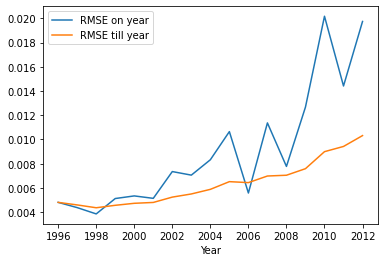

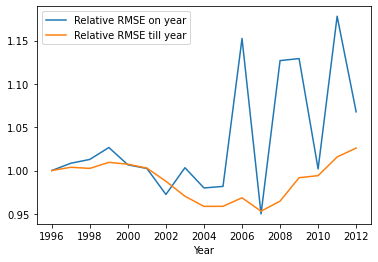

In [30]:
munic_yearly_adoption_untill_2020 = munic_yearly_adoption.loc[munic_yearly_adoption.index.get_level_values('Year') <= 2012]
micro_validation(munic_yearly_adoption_untill_2020, munic_adoption_real_pred)

### Qualitative

In [31]:
munic_adoption_real_pred_dist = munic_adoption_real_pred.copy()
munic_adoption_real_pred_dist.rename(columns={"adoption_in_year": "Observed adoption",
                                              "predicted_adoption": "Predicted adoption"}, inplace=True)

#### Number of predicted adopters over time

In [32]:
mask_real = munic_adoption_real_pred_dist['Observed adoption'] > 0
real_yearly_adopters = (munic_adoption_real_pred_dist['Observed adoption'] > 0).astype(int).groupby('Year').sum()

# For prediction cannot use the averaged data --> need to do the average of the adopters in each run
pred_yearly_adopters = (munic_yearly_adoption > 0).astype(int).groupby('Year').sum()
pred_yearly_adopters_av = pred_yearly_adopters.mean(axis=1)

Saving figure Municipalities adopting over time


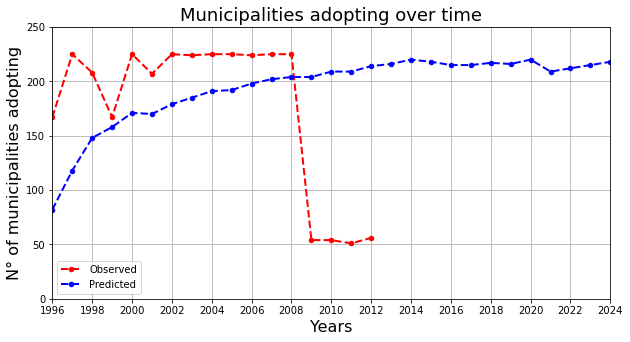

In [33]:
# Base figure
fig_title = 'Municipalities adopting over time'
fig_ad, ax_ad = plt.subplots()
fig_ad.set_size_inches(10, 5)
ax_ad.set_xlabel("Years", fontsize=16)
ax_ad.set_ylabel("N° of municipalities adopting", fontsize=16)
ax_ad.set_title(fig_title, fontsize=18)
ax_ad.set_xlim(pred_yearly_adopters.index[0], pred_yearly_adopters.index[-1])
xticks = [year for year in pred_yearly_adopters.index if year%2 == 0]
ax_ad.set_xticks(xticks)
ax_ad.set_ylim(0, 250)
ax_ad.grid(True)

# Plot adoptions
ax_ad.plot(real_yearly_adopters.index, real_yearly_adopters.values, 'r--', linewidth=2, marker='.', markersize=9,
           label='Observed')
ax_ad.plot(pred_yearly_adopters_av.index, pred_yearly_adopters_av.values, 'b--', linewidth=2, marker='.', markersize=9,
           label='Predicted')
ax_ad.legend(loc='best')

save_fig((fig_title))

#### Average adoption of only adopters over time

In [34]:
pred_av_yearly_adoption = (yearly_adoption_portugal_pred_av / pred_yearly_adopters_av)
real_av_yearly_adoption = (yearly_adoption_portugal_real['Yearly adoption'] / real_yearly_adopters)

Saving figure Average adoption (of only adopters) over time


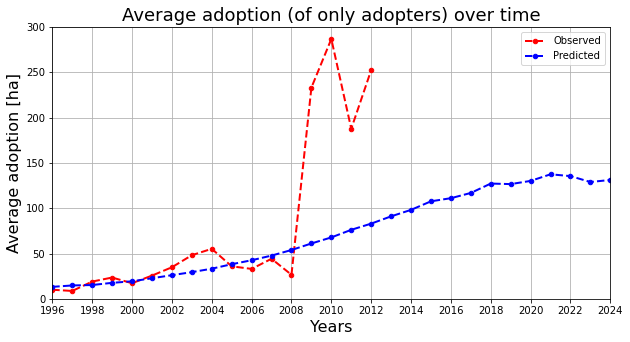

In [35]:
# Base figure
fig_title = 'Average adoption (of only adopters) over time'
fig_ad, ax_ad = plt.subplots()
fig_ad.set_size_inches(10, 5)
ax_ad.set_xlabel("Years", fontsize=16)
ax_ad.set_ylabel("Average adoption [ha]", fontsize=16)
ax_ad.set_title(fig_title, fontsize=18)
ax_ad.set_xlim(pred_av_yearly_adoption.index[0], pred_av_yearly_adoption.index[-1])
xticks = [year for year in pred_av_yearly_adoption.index if year%2 == 0]
ax_ad.set_xticks(xticks)
ax_ad.set_ylim(0, 300)
ax_ad.grid(True)

# Plot adoptions
ax_ad.plot(real_av_yearly_adoption.index, real_av_yearly_adoption.values, 'r--', linewidth=2, marker='.', markersize=9,
           label='Observed')
ax_ad.plot(pred_av_yearly_adoption.index, pred_av_yearly_adoption.values, 'b--', linewidth=2, marker='.', markersize=9,
           label='Predicted')
ax_ad.legend(loc='best')

save_fig((fig_title))

#### Ditribution of adoption in each year in each municipality

In [36]:
num_0_real = (munic_adoption_real_pred_dist["Observed adoption"] == 0).astype(int).sum()
num_0_real_str = "Total OBSERVED number of times any municipality does NOT adopt 1996-2012: " + str(num_0_real)
print(num_0_real_str)

pred_yearly_non_adopters = (munic_yearly_adoption == 0).astype(int).groupby('Year').sum()
pred_yearly_non_adopters_av = pred_yearly_adopters.mean(axis=1)
num_0_pred = round(pred_yearly_non_adopters_av.sum(), 0).astype(int)
num_0_pred_str = "Average total PREDICTED number of times any municipality does NOT adopt 1996-2012: " + str(num_0_pred)
print(num_0_pred_str)

with open("model_validation/images/Micro-validation metrics and non adopters.csv", "a", newline ='') as file:
    to_print = [" ", [num_0_real_str], [num_0_pred_str]]
    wr = csv.writer(file)
    wr.writerows(to_print)

Total OBSERVED number of times any municipality does NOT adopt 1996-2012: 1416
Average total PREDICTED number of times any municipality does NOT adopt 1996-2012: 5625


Saving figure Distribution of municipalities' adoption


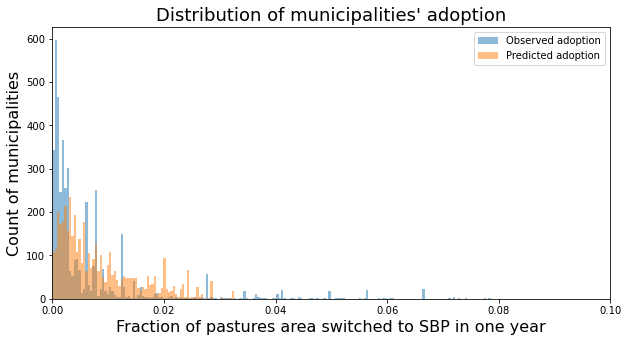

In [37]:
fig_title = "Distribution of municipalities' adoption"
munic_adoption_real_pred_dist.replace(0, None, inplace=True) # To avoid plotting 0s
ax = munic_adoption_real_pred_dist.plot.hist(figsize=(10, 5), bins=500, alpha=0.5) 
ax.set_xlabel("Fraction of pastures area switched to SBP in one year", fontsize=16)
ax.set_ylabel("Count of municipalities", fontsize=16)
ax.set_xlim(0, 0.1)
ax.set_title("Distribution of municipalities' adoption", fontsize=18)
save_fig((fig_title))

In [38]:
munic_adoption_real_pred_dist['Predicted adoption'].describe()

count   4403.000000
mean       0.008280
std        0.007046
min        0.000027
25%        0.002805
50%        0.005779
75%        0.011996
max        0.032198
Name: Predicted adoption, dtype: float64

#### Map based on adoption level for each municipality at the end of the simulation

In [39]:
import geopandas as gpd

In [40]:
def collect_agent_level_for_map(abm_model, year):
    """
    Function to collect cumulative adoption in a certain year (in ha and in fraction over pastures area)
    and the shape of the municialities in order to plot the map.
    
    Returns
    -------
    munic_cumul_adoption_and_shape : pd DataFrame
        DataFrame reporting for each muninicipality the total cumulative adoption in ha and its shape
    """
    municipality_agents = abm_model.schedule.agents
    #municipalities = [munic.Municipality for munic in municipality_agents]
    
    #munic_cumul_adoption_and_shape = pd.DataFrame(index=municipalities)
    munic_cumul_adoption_and_shape = gpd.GeoDataFrame()
    munic_cumul_adoption_and_shape['Total cumulative adoption [ha]'] = None
    munic_cumul_adoption_and_shape['Total cumulative adoption [fraction]'] = None
    munic_cumul_adoption_and_shape['geometry'] = None
    
    for munic in municipality_agents:
        yearly_adoption_until_year_ha = [v for k, v in munic.yearly_adoption_ha.items()
                                        if k <= year]
        munic_tot_cumul_adoption_year_ha = sum(yearly_adoption_until_year_ha)
        
        yearly_adoption_until_year = [v for k, v in munic.yearly_adoption.items()
                                     if k <= year]
        munic_tot_cumul_adoption_year = sum(yearly_adoption_until_year)
        
        munic_cumul_adoption_and_shape.loc[munic.Municipality] = (
            munic_tot_cumul_adoption_year_ha, 
            munic_tot_cumul_adoption_year,
            munic.shape
        )
    
    return munic_cumul_adoption_and_shape

In [41]:
year_for_map = 2012

In [42]:
pred_for_map = collect_agent_level_for_map(model, year_for_map)

In [43]:
# Collect observed adoption in year
geometry = pred_for_map['geometry']
munic_map_adoption_real = munic_yearly_adoption_real.loc[munic_yearly_adoption_real.index.get_level_values(1) == year_for_map]
munic_map_adoption_real.index = munic_map_adoption_real.index.droplevel(1)

real_for_map = pd.concat([munic_map_adoption_real['tot_cumul_adoption_until_year_ha'], geometry], axis=1)
real_for_map = gpd.GeoDataFrame(real_for_map)

Plot of area adopted in hectares

In [44]:
import contextily as ctx
import matplotlib

def plot_maps_no_0s(geodata, column_data, leg_label, fig_title):
    """
    To plot maps side by side.
    Inputs to be given as lists of two elements, the first referring to the predicted adoption and the second to the
    observed one.
    
    For additional options for plotting with geopandas see https://geopandas.org/mapping.html
    For different backgrounds see https://contextily.readthedocs.io/en/latest/providers_deepdive.html
    """
    fig, axis = plt.subplots(ncols=len(geodata), figsize=(15, 8))
    fig.suptitle(fig_title, fontsize=18)

    for i in range(len(geodata)):
        geodata_no_0 = geodata[i].loc[geodata[i][column_data[i]] != 0]
        geodata_no_0.crs = "EPSG:3857"
        transparency = 0.6
        if i == 0: # Legend scale based on predicted values
            sc_min = 10#min(geodata_no_0['Total cumulative adoption [ha]'])
            sc_max = max(geodata_no_0['Total cumulative adoption [ha]']) 
        geodata_no_0.plot(ax=axis[i], column=column_data[i],
                          cmap="OrRd", #cmap='coolwarm',
                          alpha=transparency, edgecolor='k',
                          legend=True, norm=matplotlib.colors.LogNorm(vmin=sc_min, vmax=sc_max),
                          legend_kwds={'label': leg_label[i]})
        ctx.add_basemap(axis[i], source=ctx.providers.Stamen.Terrain)

    save_fig((fig_title))

Saving figure Predicted vs observed adoption spatial distribution [ha]


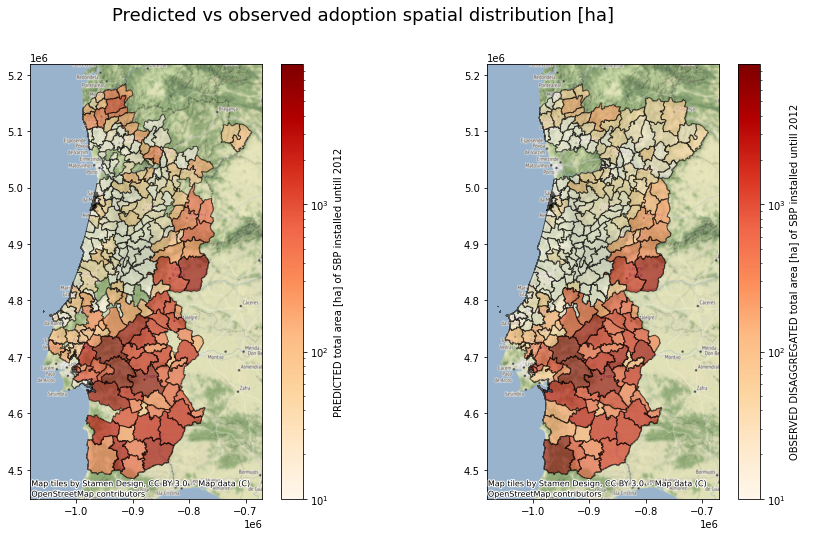

In [45]:
pred_leg_label = "PREDICTED total area [ha] of SBP installed untill " + str(year_for_map)
real_leg_label = "OBSERVED DISAGGREGATED total area [ha] of SBP installed untill " + str(year_for_map)
plot_maps_no_0s([pred_for_map, real_for_map], ['Total cumulative adoption [ha]', 'tot_cumul_adoption_until_year_ha'],
                [pred_leg_label, real_leg_label], "Predicted vs observed adoption spatial distribution [ha]")

Plot of fraction of pastures area adopted (**Not for validation since not compared with real one move to experiments only**)

In [46]:
import contextily as ctx

def plot_map_no_0s(geodata, column_data, leg_label):
    """
    To plot only one map.
    
    For other options for plotting with geopandas see https://geopandas.org/mapping.html
    """
    geodata_no_0 = geodata.loc[geodata[column_data] != 0]
    geodata_no_0.crs = "EPSG:3857"
    transparency = 0.6
    ax = geodata_no_0.plot(figsize=(10, 8), column=column_data,
                            cmap="OrRd", alpha=transparency, edgecolor='k',
                            legend=True,
                            legend_kwds={'label': leg_label})
    ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain)    

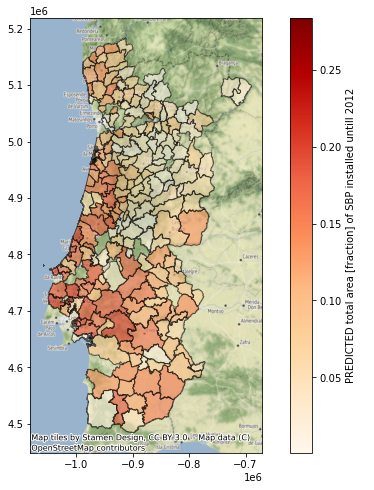

In [47]:
frac_leg_label = "PREDICTED total area [fraction] of SBP installed untill " + str(year_for_map)
plot_map_no_0s(pred_for_map, 'Total cumulative adoption [fraction]', frac_leg_label)